In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from influence import Influence
from mnist_models import Model
from utils import corrupt_mnist, Dataset, leave_one_out_dataset
from IPython.display import clear_output

np.random.seed(1)

FLAGS = None

# Import data
mnist = corrupt_mnist(input_data.read_data_sets("mnist_data", one_hot=True), 0.0)

testset = Dataset( (mnist.test.images, mnist.test.labels) )
trainset = Dataset ((mnist.train.images, mnist.train.labels) )

sess = tf.InteractiveSession()
model = Model("convnet", trainset, testset, sess)

saver = tf.train.Saver()

tf.global_variables_initializer().run()

summary_writter = tf.summary.FileWriter("./Hvp_summaries", sess.graph)

checkpoint_file = "/home/cgel/deep_quad/checkpoints/convnet.ckpt"

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [2]:
load = True
save = False
if not load:
    model.train(vervose=2)
    if save == True:
        saver.save(sess, checkpoint_file)
else:
    saver.restore(sess, checkpoint_file)

In [3]:
scale = float(len(trainset.labels)) * 10
inf = Influence(model.cross_entropy, testset, model.cross_entropy, trainset, model.input_ph, model.y_, scale, cg_iters = 100, dampening=0.0001, vervose=1)

In [4]:
load_s = False
if load_s:
    inf.load_s("s_cache")
else:
    inf.compute_s()

Initial error: 2884.82037105
Final error: 0.00269135129188


In [210]:
model.testset_loss()

652.41949

## Influence vs leave one out

In [5]:
# compute the influences for every image in the training set
trainset_influence_map = []
trainset_influence = []
trainset_grads = []
for i in range(len(mnist.train.labels)):
    z = (mnist.train.images[i:i+1], mnist.train.labels[i:i+1])
    influ, z_grad = inf.of_and_g(z)
    trainset_influence.append(influ)
    trainset_grads.append(z_grad)
    trainset_influence_map.append( (influ, i))
    if i % 10000==0:
        print(i)

None
True


Exception: Before computing the influence of z, s needs to be computed

In [71]:
# generate a list ordering the examples of the training set by most influential
abs_influence = [ (abs(i_influ), i) for i_influ, i in trainset_influence_map]
abs_influence.sort(reverse=True)
rank = [ (trainset_influence[j], j) for _, j in abs_influence]

In [7]:
influence_acc = []
grads_l = []
infs = []
d_losses = []

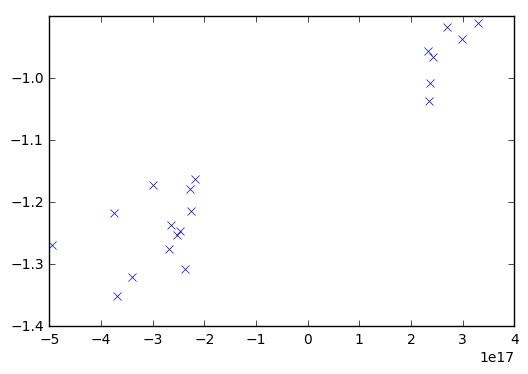

In [8]:
# leave one out retraining 
subset = rank[0:20]
saver.restore(sess, checkpoint_file)
base_testset_loss = model.testset_loss()
for _,i in subset:
    z = (trainset.images[i:i+1], trainset.labels[i:i+1])
    z_influ, z_grad = inf.of_and_g(z)
    grads_l.append(z_grad)
    model.trainset = leave_one_out_dataset(trainset, i)
    model.update(10000, learning_rate=1e-7)
    d_loss = base_testset_loss - model.testset_loss()
    print(i, ":  ", z_influ, d_loss)
    influence_acc.append( (z_influ, d_loss) )
    infs.append(z_influ )
    d_losses.append(d_loss)
    saver.restore(sess, checkpoint_file)
    clear_output()
    plt.plot(infs, d_losses, "x")
    plt.show()
    
model.trainset = trainset

## Simple influence vs leave one out

In [187]:
def simple_influence(z):
    z_grad = sess.run(model.grads, {model.input_ph:z[0], model.y_:z[1] } )
    return -inf.evalset_func_grads.dot(z_grad)

In [188]:
# compute the simple influences for every image in the training set
trainset_simple_influence_map = []
trainset_simple_influence = []
for i in range(len(mnist.train.labels)):
    z = (mnist.train.images[i:i+1], mnist.train.labels[i:i+1])
    influ = simple_influence(z)
    trainset_simple_influence.append(influ)
    trainset_simple_influence_map.append( (influ, i))
    if i % 10000==0:
        print(i)
print("Done")

0
10000
20000
30000
40000
50000


In [190]:
# generate a list ordering the examples of the training set by most influential
abs_simple_influence = [ (abs(i_influ), i) for i_influ, i in trainset_simple_influence_map]
abs_simple_influence.sort(reverse=True)
simple_rank = [ (trainset_simple_influence[j], j) for _, j in abs_simple_influence]

In [193]:
s_infs = []
s_simple_infs = []
s_d_losses = []

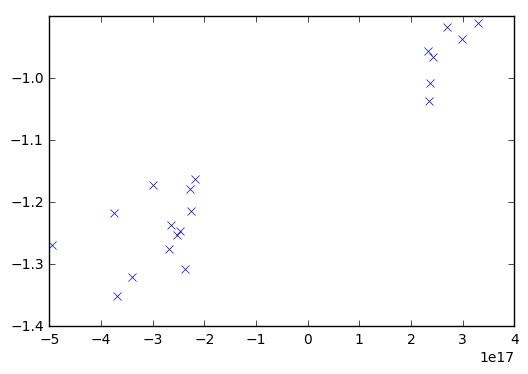

In [194]:
# leave one out retraining 
subset = simple_rank[0:20]
saver.restore(sess, checkpoint_file)
base_testset_loss = model.testset_loss()
for _,i in subset:
    z = (trainset.images[i:i+1], trainset.labels[i:i+1])
    # compute influence
    z_influ, z_grad = inf.of_and_g(z)
    s_infs.append(z_influ )
    # compute simple influence
    s_simple_infs.append(simple_influence(z))
    # leave one out retraining
    model.trainset = leave_one_out_dataset(trainset, i)
    model.update(10000, learning_rate=1e-7)
    s_d_losses.append(base_testset_loss - model.testset_loss())
    
    # restore and plot
    saver.restore(sess, checkpoint_file)
    clear_output()
    plt.plot(s_infs, s_d_losses, "x")
    plt.show()
    
model.trainset = trainset

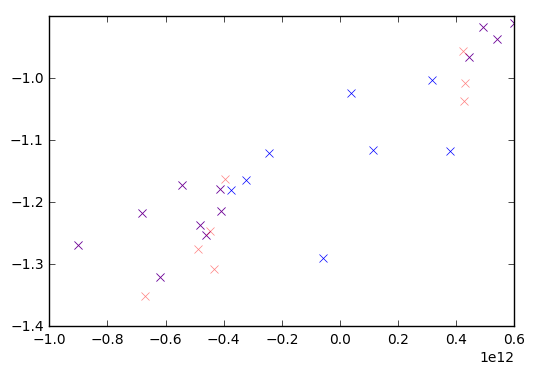

In [209]:
plt.plot(s_infs, s_d_losses, "x")
plt.plot(np.array(infs)/scale, d_losses, "x", color="red", alpha=0.5)

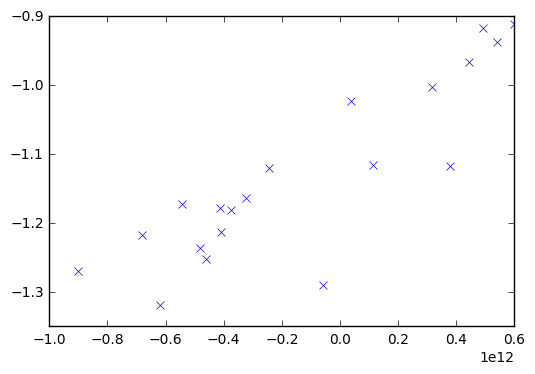

In [200]:
plt.plot(s_infs, s_d_losses, "x")

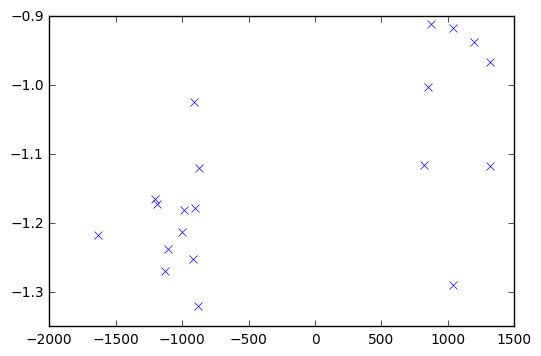

In [196]:
plt.plot(s_simple_infs, s_d_losses, "x")

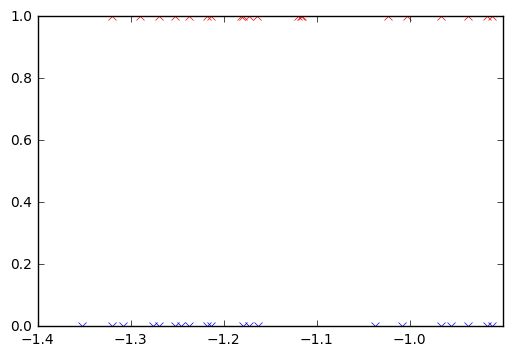

In [207]:
plt.plot(s_d_losses, [1]*20, "x", color="red")
plt.plot(d_losses, [0]*20, "x")

In [ ]:
def plot_mnist_image(x):
    plt.imshow(x.reshape((28,28)))
    plt.set_cmap('gray')